# North Atlantic O2
    - This script shows a workflow of estimating O2 and a few ML regressors
    - O2 is estimated as a function of T, S, Stratification, MLD, long, lat, time
    - time is measured in the units of month since 1965-01
    - Estimation methods include Multiple Linear Regression, Support Vector Machine, and Neural Network
    - 85-15 divide between training and test data
    - K-fold cross validation for hyperparameter tuning for SVM, shallow and deep NN
    - Warning: this calculation takes a while!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import sklearn as skl
import gsw

### First prepare O2, T, S, stratification data

In [2]:
# access model output
# observational data 
#diro = '/glade/campaign/univ/ugit0034/WOD18_OSDCTD/'
diro = '/glade/campaign/univ/ugit0034/WOD18_OSDCTD/'
#dirf = '/glade/campaign/univ/ugit0034/EN4/L09_20x180x360/'
fosd='_1x1bin_osd_'
fctd='_1x1bin_ctd_'
fmer='_1x1bin_merged_'
var=['o2','TSN2']

In [3]:
# select depth level
zlev=500
yrs=np.arange(1965,2021,1)
Nt=np.size(yrs)*12
#
o2=np.zeros((Nt,180,360))
t=np.zeros((Nt,180,360))
s=np.zeros((Nt,180,360))
sig0=np.zeros((Nt,180,360))
N2=np.zeros((Nt,180,360))
mld=np.zeros((Nt,180,360))
#
for year in yrs:
    #print(str(year))
    ds=xr.open_dataset(diro+var[0]+fmer+str(year)+'.nc')
    tr=12*(year-1965)
    o2[tr:(tr+12),:,:]=ds.o2.sel(depth=zlev).to_numpy()
    ds=xr.open_dataset(diro+var[1]+fosd+str(year)+'.nc')
    t[tr:(tr+12),:,:]=ds.CT.sel(depth=zlev).to_numpy()
    s[tr:(tr+12),:,:]=ds.SA.sel(depth=zlev).to_numpy()
    sig0[tr:(tr+12),:,:]=ds.sigma0.sel(depth=zlev).to_numpy()
    N2[tr:(tr+12),:,:]=ds.N2.sel(depth=zlev).to_numpy()
    mld[tr:(tr+12),:,:]=ds.MLD_125.to_numpy()

In [4]:
# basin mask
dsm=xr.open_dataset('/glade/work/ito/dataset/model/basin_mask_01.nc')
# observation coordinates
dsd=xr.open_dataset('/glade/work/ito/dataset/model/mask_woagrid_196501-201412.nc')

In [5]:
# get coordinates
x=ds.lon.to_numpy()
y=ds.lat.to_numpy()
xi=np.arange(0,360,1)
yi=np.arange(0,180,1)
xx,yy=np.meshgrid(x,y)
xxi,yyi=np.meshgrid(xi,yi)

In [6]:
# extract data in the Atlantic basin at 500m depth
mask= dsm.basin_mask.sel(depth=zlev)
NN = np.shape(o2)

/glade/scratch/ito/ipykernel_282383/2571040511.py:4: RuntimeWarning: Mean of empty slice
  ax[0,1].pcolormesh(xx,yy,np.nanmean(o2,0))
/glade/scratch/ito/ipykernel_282383/2571040511.py:5: RuntimeWarning: Mean of empty slice
  ax[1,0].pcolormesh(xx,yy,np.nanmean(s,0))
/glade/scratch/ito/ipykernel_282383/2571040511.py:6: RuntimeWarning: Mean of empty slice
  ax[1,1].pcolormesh(xx,yy,np.nanmean(t,0))
/glade/scratch/ito/ipykernel_282383/2571040511.py:7: RuntimeWarning: Mean of empty slice
  ax[2,0].pcolormesh(xx,yy,np.nanmean(N2,0))
/glade/scratch/ito/ipykernel_282383/2571040511.py:8: RuntimeWarning: Mean of empty slice
  ax[2,1].pcolormesh(xx,yy,np.nanmean(mld,0))


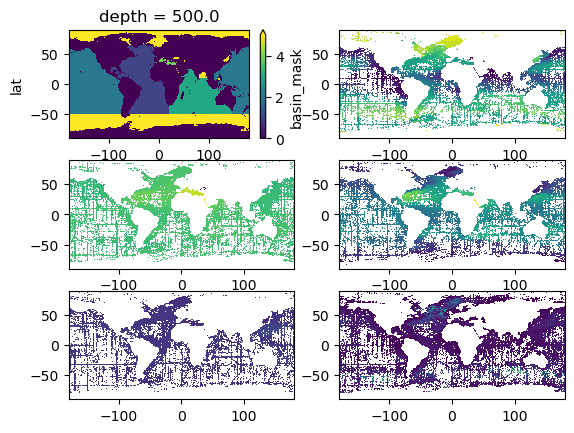

In [7]:
# take a look at the data
fig,ax=plt.subplots(3,2)
mask.plot(ax=ax[0,0],vmin=0,vmax=5,label='basin_mask')
ax[0,1].pcolormesh(xx,yy,np.nanmean(o2,0))
ax[1,0].pcolormesh(xx,yy,np.nanmean(s,0))
ax[1,1].pcolormesh(xx,yy,np.nanmean(t,0))
ax[2,0].pcolormesh(xx,yy,np.nanmean(N2,0))
ax[2,1].pcolormesh(xx,yy,np.nanmean(mld,0))

In [8]:
# select Atlantic basin
# Atlantic is mask = 1
ma = dsm.basin_mask.sel(depth=zlev).to_numpy()

In [9]:
# subtract climatology from the discrete data to define anomalies
doa=o2
dsa=s
dta=t
dra=N2
dha=mld
#
# prepare lat lon data
xx1 = np.tile(xx,[Nt,1,1])
yy1 = np.tile(yy,[Nt,1,1])
tt0 = np.tile(np.arange(0,Nt,1),[180,360,1])
tt1 = np.transpose(tt0,(2,0,1))

In [10]:
# apply mask for the north atlantic
doa=np.where((ma==1)&(yy>0),doa,np.nan)
dsa=np.where((ma==1)&(yy>0),dsa,np.nan)
dta=np.where((ma==1)&(yy>0),dta,np.nan)
dra=np.where((ma==1)&(yy>0),dra,np.nan)
dha=np.where((ma==1)&(yy>0),dha,np.nan)

### Now we have the anormaly data for the North Atlantic. Remove NaNs and organize them into 1d array

In [11]:
# create data vector
doa0 = doa.flatten()
dsa0 = dsa.flatten()
dta0 = dta.flatten()
dra0 = dra.flatten()
dha0 = dha.flatten()
xx0  = xx1.flatten()
yy0  = yy1.flatten()
tt0  = tt1.flatten()

In [12]:
# remove nan
dd = doa0 + dsa0 + dta0 + dra0 + dha0
doa1=doa0[np.isnan(dd)==False]
dsa1=dsa0[np.isnan(dd)==False]
dta1=dta0[np.isnan(dd)==False]
dra1=dra0[np.isnan(dd)==False]
dha1=dha0[np.isnan(dd)==False]
xx1=xx0[np.isnan(dd)==False]
yy1=yy0[np.isnan(dd)==False]
tt1=tt0[np.isnan(dd)==False]
Nsample = np.size(doa1)
print(Nsample)

14124


In [13]:
# generate data matrix and standardize it
X = np.array([dsa1, dta1, dra1, dha1, xx1, yy1, tt1])
y = doa1
#
Xm = np.mean(X,axis=1)
Xstd = np.std(X,axis=1)
#
N=np.size(y)
# normalize x and y
Xa = (X.T - Xm)/Xstd
ym = np.mean(y)
ystd = np.std(y)
ya = (y-ym)/ystd

## ML

### First split the data into training and test set

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Xa, ya,random_state=1,test_size=0.15)

In [15]:
a=y_train.size
b=y_test.size
a/(a+b)

0.8499716794109318

### MLR estimator (MLregr)

In [16]:
##
## Multiple Linear Regression
##
from sklearn.linear_model import LinearRegression

In [17]:
# fit model
MLregr = LinearRegression().fit(X_train, y_train)
#MLregr.coef_
#MLregr.intercept_
out=MLregr.predict(X_test)

0.8132989768320846
correlation =  0.9019787855216648
RMSE =  23.580426485127166


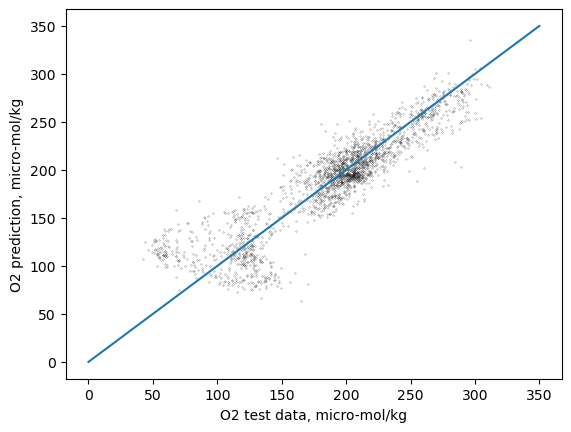

In [18]:
# test model output
score=MLregr.score(X_test, y_test)
print(score)
o2est = out*ystd + ym
o2test= y_test*ystd + ym
plt.plot(o2test,o2est,'k.',markersize=.3)
plt.plot([0,350],[0,350])
plt.ylabel('O2 prediction, micro-mol/kg')
plt.xlabel('O2 test data, micro-mol/kg')
temp=np.corrcoef(o2est,o2test)
Rval_MLR=temp[0,1]
print('correlation = ',Rval_MLR)
RMSE_MLR=np.sqrt(np.mean((o2est-o2test)**2))
print('RMSE = ',RMSE_MLR)

### Support Vector Machine estimator (SVregr)

In [19]:
##
## Support Vector Regression
##
import sklearn.svm as svm
from sklearn.model_selection import GridSearchCV

In [20]:
clf = svm.SVR()
parameters = {'C':[1, 5, 10],'epsilon':[.1,.2,.5]}
SVregr = GridSearchCV(clf, parameters)
SVregr.fit(X_train, y_train)

GridSearchCV(estimator=SVR(),
             param_grid={'C': [1, 5, 10], 'epsilon': [0.1, 0.2, 0.5]})

In [21]:
SVregr.cv_results_

{'mean_fit_time': array([3.37995496, 1.69435415, 0.3397831 , 4.92310739, 2.31277075,
        0.33991261, 6.60209131, 2.99031816, 0.37044473]),
 'std_fit_time': array([0.06550488, 0.10311477, 0.02691214, 0.07284618, 0.07291159,
        0.00255449, 0.18103134, 0.06298873, 0.00708675]),
 'mean_score_time': array([0.94130635, 0.46238213, 0.07482319, 0.91077337, 0.43734617,
        0.06796889, 0.90034776, 0.42601085, 0.06815491]),
 'std_score_time': array([0.00830261, 0.01060441, 0.00184135, 0.01521522, 0.00488325,
        0.00087969, 0.02306342, 0.00189758, 0.00143859]),
 'param_C': masked_array(data=[1, 1, 1, 5, 5, 5, 10, 10, 10],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'param_epsilon': masked_array(data=[0.1, 0.2, 0.5, 0.1, 0.2, 0.5, 0.1, 0.2, 0.5],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?

In [22]:
# use the best fit parameter
out=SVregr.predict(X_test)

correlation =  0.9795292864344453
RMSE =  10.998026639474771


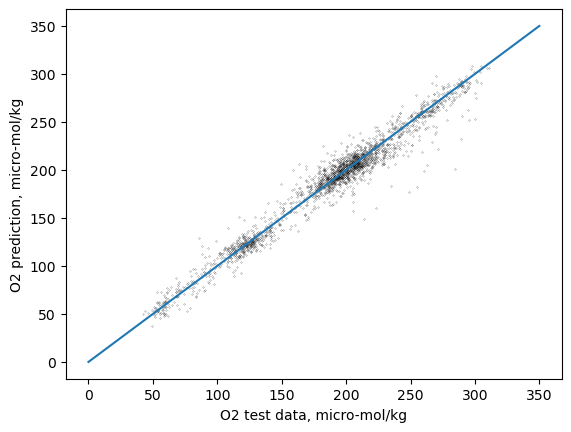

In [23]:
o2est = out*ystd + ym
o2test= y_test*ystd + ym
#
plt.plot(o2test,o2est,'k.',markersize=.3)
plt.plot([0,350],[0,350])
plt.ylabel('O2 prediction, micro-mol/kg')
plt.xlabel('O2 test data, micro-mol/kg')
temp=np.corrcoef(o2est,o2test)
Rval_SV=temp[0,1]
print('correlation = ',Rval_SV)
RMSE_SV=np.sqrt(np.mean((o2est-o2test)**2))
print('RMSE = ',RMSE_SV)

### Neural Network estimator (NNregr)

In [24]:
## NN
from sklearn.neural_network import MLPRegressor

In [25]:
# shallow NN
clf = MLPRegressor(max_iter=1000)
parameters = {'hidden_layer_sizes':[[10,10],[20,20],[40,40]],'alpha':[.0001,.001,.01]}
NNregr = GridSearchCV(clf, parameters)

In [26]:
NNregr.fit(X_test,y_test)

GridSearchCV(estimator=MLPRegressor(max_iter=1000),
             param_grid={'alpha': [0.0001, 0.001, 0.01],
                         'hidden_layer_sizes': [[10, 10], [20, 20], [40, 40]]})

In [27]:
out = NNregr.predict(X_test)
NNregr.cv_results_

{'mean_fit_time': array([0.55576582, 0.52091923, 0.63608952, 0.56485438, 0.52719693,
        0.71513891, 0.58499613, 0.54437933, 0.61520143]),
 'std_fit_time': array([0.05936258, 0.06081396, 0.15215738, 0.10572308, 0.06908399,
        0.11973309, 0.10020972, 0.06269968, 0.07400395]),
 'mean_score_time': array([0.00047016, 0.00048027, 0.00052366, 0.00045757, 0.00047865,
        0.0005569 , 0.00047202, 0.00047607, 0.00050435]),
 'std_score_time': array([1.10970979e-05, 2.45744681e-06, 1.87904094e-05, 8.41235893e-06,
        1.07352979e-05, 8.35315271e-05, 2.63994725e-05, 7.49013890e-06,
        1.41208222e-05]),
 'param_alpha': masked_array(data=[0.0001, 0.0001, 0.0001, 0.001, 0.001, 0.001, 0.01,
                    0.01, 0.01],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'param_hidden_layer_sizes': masked_array(data=[list([10, 10]), list([20, 20]), list([40, 40]),
           

correlation =  0.9839479629932433
RMSE =  9.99351617003865


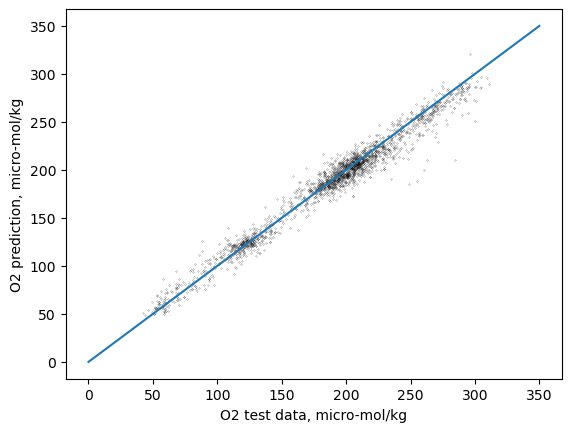

In [28]:
o2est = out*ystd + ym
o2test= y_test*ystd + ym
#
plt.plot(o2test,o2est,'k.',markersize=.3)
plt.plot([0,350],[0,350])
plt.ylabel('O2 prediction, micro-mol/kg')
plt.xlabel('O2 test data, micro-mol/kg')
temp=np.corrcoef(o2est,o2test)
Rval_NN=temp[0,1]
print('correlation = ',Rval_NN)
RMSE_NN=np.sqrt(np.mean((o2est-o2test)**2))
print('RMSE = ',RMSE_NN)

### deep Neural Network estimator (dNNregr)

In [29]:
# deep NN 30-30-30-5
dNNregr = MLPRegressor(max_iter=1000).fit(X_train, y_train)

In [30]:
clf = MLPRegressor(max_iter=1000)
parameters = {'hidden_layer_sizes':[[10,10,10,10],[20,20,20,20],[40,40,40,40]],'alpha':[.0001,.001,.01]}
dNNregr = GridSearchCV(clf, parameters)

In [31]:
dNNregr.fit(X_test,y_test)

GridSearchCV(estimator=MLPRegressor(max_iter=1000),
             param_grid={'alpha': [0.0001, 0.001, 0.01],
                         'hidden_layer_sizes': [[10, 10, 10, 10],
                                                [20, 20, 20, 20],
                                                [40, 40, 40, 40]]})

In [32]:
out = dNNregr.predict(X_test)
dNNregr.cv_results_

{'mean_fit_time': array([0.8071167 , 0.70535016, 0.98636279, 0.74030504, 0.62817211,
        1.07273211, 0.70934229, 0.77244997, 0.99238095]),
 'std_fit_time': array([0.13850822, 0.17755306, 0.14071276, 0.13110664, 0.06600822,
        0.19966973, 0.08425305, 0.17341814, 0.17227837]),
 'mean_score_time': array([0.00050893, 0.0005693 , 0.00062447, 0.00050197, 0.00052562,
        0.00060906, 0.00050502, 0.00057812, 0.00062985]),
 'std_score_time': array([2.37819874e-05, 7.76759388e-05, 3.43813810e-05, 4.85016293e-06,
        9.41146583e-06, 2.02757305e-05, 2.67587656e-05, 8.49508382e-05,
        2.63684481e-05]),
 'param_alpha': masked_array(data=[0.0001, 0.0001, 0.0001, 0.001, 0.001, 0.001, 0.01,
                    0.01, 0.01],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'param_hidden_layer_sizes': masked_array(data=[list([10, 10, 10, 10]), list([20, 20, 20, 20]),
           

correlation =  0.9853772770203925
RMSE =  9.479910641484109


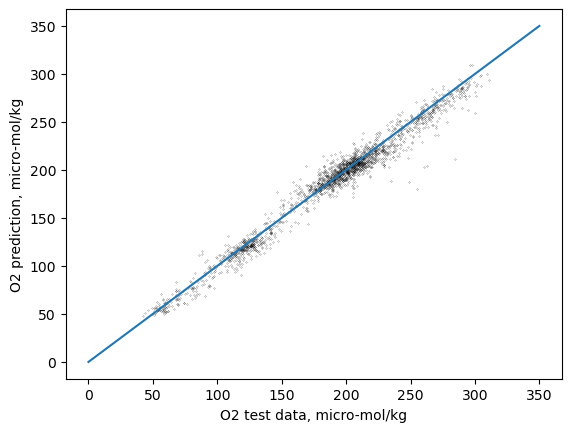

In [33]:
o2est = out*ystd + ym
o2test= y_test*ystd + ym
#
plt.plot(o2test,o2est,'k.',markersize=.3)
plt.plot([0,350],[0,350])
plt.ylabel('O2 prediction, micro-mol/kg')
plt.xlabel('O2 test data, micro-mol/kg')
temp=np.corrcoef(o2est,o2test)
Rval_NN=temp[0,1]
print('correlation = ',Rval_NN)
RMSE_NN=np.sqrt(np.mean((o2est-o2test)**2))
print('RMSE = ',RMSE_NN)